# 🔬 Vision Transformer (ViT-Tiny) — CIFAR-10
**Vision Transformers**

| Setting | Value |
|---|---|
| Model | ViT-Tiny (5.3M params) |
| Dataset | CIFAR-10 (50k train / 10k test) |
| Optimizer | AdamW + Cosine LR + Warmup |
| Target | >75% test accuracy |

---

## ✅ Step 1 — Verify GPU

In [15]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')

if torch.cuda.is_available():
    print(f'GPU: {torch.cuda.get_device_name(0)}')
    print(f'VRAM: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB')
    print(f'CUDA version: {torch.version.cuda}')
else:
    print('⚠️  No GPU detected. Go to Runtime → Change runtime type → T4 GPU')

Device: cuda
GPU: Tesla T4
VRAM: 15.6 GB
CUDA version: 12.6


## 📦 Step 2 — Imports

In [16]:
import os
import math
import time
import logging
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from datetime import datetime
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms

# Reproducibility
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.backends.cudnn.benchmark = True   # Faster convolutions
    torch.backends.cudnn.deterministic = False

print('✓ All imports successful')
print(f'PyTorch version: {torch.__version__}')

✓ All imports successful
PyTorch version: 2.9.0+cu126


## ⚙️ Step 3 — Configuration

In [17]:
# ============================================================
# CONFIG — adjust these to experiment
# ============================================================
CONFIG = {
    # Model
    'image_size':      32,
    'patch_size':      4,
    'num_classes':     10,
    'embed_dim':       192,
    'depth':           12,
    'num_heads':       3,
    'mlp_ratio':       4.0,
    'dropout':         0.1,
    'attn_dropout':    0.0,

    # Training
    'num_epochs':      100,
    'batch_size':      128,   # Doubled from CPU version — GPU can handle it
    'peak_lr':         1e-3,
    'weight_decay':    0.05,
    'warmup_epochs':   10,
    'label_smoothing': 0.1,
    'grad_clip':       1.0,

    # Data augmentation (stronger than CPU version)
    'use_mixup':       True,
    'mixup_alpha':     0.2,
    'use_cutmix':      True,
    'cutmix_alpha':    1.0,

    # Checkpointing
    'save_dir':        'checkpoints',
    'resume_from':     None,   # Set to checkpoint path to resume, e.g. 'checkpoints/best.pth'
}

# Derived
CONFIG['num_patches'] = (CONFIG['image_size'] // CONFIG['patch_size']) ** 2

os.makedirs(CONFIG['save_dir'], exist_ok=True)

print('Configuration:')
for k, v in CONFIG.items():
    print(f'  {k:<20} {v}')

Configuration:
  image_size           32
  patch_size           4
  num_classes          10
  embed_dim            192
  depth                12
  num_heads            3
  mlp_ratio            4.0
  dropout              0.1
  attn_dropout         0.0
  num_epochs           100
  batch_size           128
  peak_lr              0.001
  weight_decay         0.05
  warmup_epochs        10
  label_smoothing      0.1
  grad_clip            1.0
  use_mixup            True
  mixup_alpha          0.2
  use_cutmix           True
  cutmix_alpha         1.0
  save_dir             checkpoints
  resume_from          None
  num_patches          64


## 🗃️ Step 4 — Data Loading with Augmentation

In [18]:
CIFAR10_MEAN = (0.4914, 0.4822, 0.4465)
CIFAR10_STD  = (0.2470, 0.2435, 0.2616)

# Training augmentation — aggressive for ViT (data-hungry model)
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.TrivialAugmentWide(),          # State-of-the-art augmentation policy
    transforms.ToTensor(),
    transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD),
    transforms.RandomErasing(p=0.25),         # Helps ViT learn global features
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD),
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,  download=True, transform=train_transform)
test_dataset  = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)

train_loader = DataLoader(
    train_dataset, batch_size=CONFIG['batch_size'],
    shuffle=True, num_workers=2, pin_memory=True,
    persistent_workers=False   # Changed for kaggle enviornment 
)
test_loader = DataLoader(
    test_dataset, batch_size=CONFIG['batch_size'] * 2,
    shuffle=False, num_workers=2, pin_memory=True,
    persistent_workers=False   # Changed for kaggle enviornment
)

CLASSES = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

print(f'Train samples: {len(train_dataset):,}')
print(f'Test  samples: {len(test_dataset):,}')
print(f'Train batches: {len(train_loader):,}  (batch={CONFIG["batch_size"]})')
print(f'Test  batches: {len(test_loader):,}')

Train samples: 50,000
Test  samples: 10,000
Train batches: 391  (batch=128)
Test  batches: 40


## 🏗️ Step 5 — ViT-Tiny Architecture

In [19]:
class PatchEmbedding(nn.Module):
    """Split image into patches and project to embedding dim."""
    def __init__(self, image_size, patch_size, in_channels=3, embed_dim=192):
        super().__init__()
        self.num_patches = (image_size // patch_size) ** 2
        # Conv2d as a patch extractor — equivalent to linear projection but faster
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)
        self.norm = nn.LayerNorm(embed_dim)

    def forward(self, x):
        x = self.proj(x)           # (B, embed_dim, H/P, W/P)
        x = x.flatten(2)           # (B, embed_dim, num_patches)
        x = x.transpose(1, 2)      # (B, num_patches, embed_dim)
        return self.norm(x)


class MultiHeadSelfAttention(nn.Module):
    """Efficient multi-head self-attention with optional flash attention."""
    def __init__(self, embed_dim, num_heads, attn_dropout=0.0):
        super().__init__()
        assert embed_dim % num_heads == 0
        self.num_heads = num_heads
        self.head_dim  = embed_dim // num_heads
        self.scale     = self.head_dim ** -0.5

        self.qkv  = nn.Linear(embed_dim, embed_dim * 3, bias=False)
        self.proj = nn.Linear(embed_dim, embed_dim)
        self.attn_drop = nn.Dropout(attn_dropout)

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, self.head_dim)
        qkv = qkv.permute(2, 0, 3, 1, 4)   # (3, B, heads, N, head_dim)
        q, k, v = qkv.unbind(0)

        # Use PyTorch scaled_dot_product_attention if available (Flash Attention)
        if hasattr(F, 'scaled_dot_product_attention'):
            x = F.scaled_dot_product_attention(q, k, v, dropout_p=self.attn_drop.p if self.training else 0.0)
        else:
            attn = (q @ k.transpose(-2, -1)) * self.scale
            attn = attn.softmax(dim=-1)
            attn = self.attn_drop(attn)
            x = attn @ v

        x = x.transpose(1, 2).reshape(B, N, C)
        return self.proj(x)


class MLP(nn.Module):
    """Feed-forward block with GELU activation."""
    def __init__(self, embed_dim, mlp_ratio=4.0, dropout=0.0):
        super().__init__()
        hidden = int(embed_dim * mlp_ratio)
        self.net = nn.Sequential(
            nn.Linear(embed_dim, hidden),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden, embed_dim),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)


class TransformerBlock(nn.Module):
    """Pre-norm transformer block (more stable than post-norm)."""
    def __init__(self, embed_dim, num_heads, mlp_ratio=4.0, dropout=0.0, attn_dropout=0.0):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn  = MultiHeadSelfAttention(embed_dim, num_heads, attn_dropout)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.mlp   = MLP(embed_dim, mlp_ratio, dropout)
        self.drop  = nn.Dropout(dropout)

    def forward(self, x):
        x = x + self.drop(self.attn(self.norm1(x)))   # Residual connection
        x = x + self.drop(self.mlp(self.norm2(x)))    # Residual connection
        return x


class ViTTiny(nn.Module):
    """
    Vision Transformer - Tiny variant.
    Based on: Dosovitskiy et al. 2020 (https://arxiv.org/abs/2010.11929)
    Config matches DeiT-Tiny: embed_dim=192, depth=12, heads=3
    """
    def __init__(self, cfg):
        super().__init__()
        self.patch_embed = PatchEmbedding(
            cfg['image_size'], cfg['patch_size'], embed_dim=cfg['embed_dim']
        )
        num_patches = cfg['num_patches']

        # Learnable CLS token and positional embeddings
        self.cls_token = nn.Parameter(torch.zeros(1, 1, cfg['embed_dim']))
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, cfg['embed_dim']))
        self.pos_drop  = nn.Dropout(cfg['dropout'])

        self.blocks = nn.ModuleList([
            TransformerBlock(
                cfg['embed_dim'], cfg['num_heads'], cfg['mlp_ratio'],
                cfg['dropout'], cfg['attn_dropout']
            )
            for _ in range(cfg['depth'])
        ])

        self.norm = nn.LayerNorm(cfg['embed_dim'])
        self.head = nn.Linear(cfg['embed_dim'], cfg['num_classes'])

        self._init_weights()

    def _init_weights(self):
        # Follows original ViT initialisation
        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        nn.init.trunc_normal_(self.cls_token, std=0.02)
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.trunc_normal_(m.weight, std=0.02)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.LayerNorm):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        B = x.shape[0]
        x = self.patch_embed(x)                                          # (B, N, D)
        cls = self.cls_token.expand(B, -1, -1)                          # (B, 1, D)
        x   = torch.cat([cls, x], dim=1)                                # (B, N+1, D)
        x   = self.pos_drop(x + self.pos_embed)

        for block in self.blocks:
            x = block(x)

        x = self.norm(x)
        return self.head(x[:, 0])                                        # CLS token → logits


# Build model
model = ViTTiny(CONFIG).to(device)

total_params     = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Total parameters:     {total_params:,}')
print(f'Trainable parameters: {trainable_params:,}')

Total parameters:     5,356,234
Trainable parameters: 5,356,234


## 🔀 Step 6 — MixUp / CutMix Augmentation

In [20]:
def mixup_data(x, y, alpha=0.2):
    """MixUp: Zhang et al. 2018 (https://arxiv.org/abs/1710.09412)"""
    lam = np.random.beta(alpha, alpha) if alpha > 0 else 1.0
    idx = torch.randperm(x.size(0), device=x.device)
    mixed_x = lam * x + (1 - lam) * x[idx]
    return mixed_x, y, y[idx], lam


def cutmix_data(x, y, alpha=1.0):
    """CutMix: Yun et al. 2019 (https://arxiv.org/abs/1905.04899)"""
    lam = np.random.beta(alpha, alpha)
    idx = torch.randperm(x.size(0), device=x.device)
    _, _, H, W = x.shape

    cut_ratio = math.sqrt(1 - lam)
    cut_h, cut_w = int(H * cut_ratio), int(W * cut_ratio)
    cx = np.random.randint(W)
    cy = np.random.randint(H)
    x1, x2 = max(cx - cut_w // 2, 0), min(cx + cut_w // 2, W)
    y1, y2 = max(cy - cut_h // 2, 0), min(cy + cut_h // 2, H)

    mixed_x = x.clone()
    mixed_x[:, :, y1:y2, x1:x2] = x[idx, :, y1:y2, x1:x2]
    lam = 1 - (y2 - y1) * (x2 - x1) / (H * W)
    return mixed_x, y, y[idx], lam


def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)


print('✓ MixUp and CutMix ready')

✓ MixUp and CutMix ready


## 🏋️ Step 7 — Optimizer, Scheduler & Loss

In [21]:
# Separate weight decay — don't apply to bias, LayerNorm, CLS token, pos embed
decay_params     = [p for n, p in model.named_parameters() if p.requires_grad and
                    not any(nd in n for nd in ['bias', 'norm', 'cls_token', 'pos_embed'])]
no_decay_params  = [p for n, p in model.named_parameters() if p.requires_grad and
                    any(nd in n for nd in ['bias', 'norm', 'cls_token', 'pos_embed'])]

optimizer = torch.optim.AdamW([
    {'params': decay_params,    'weight_decay': CONFIG['weight_decay']},
    {'params': no_decay_params, 'weight_decay': 0.0},
], lr=CONFIG['peak_lr'], betas=(0.9, 0.999))

# Linear warmup + cosine decay
def lr_lambda(epoch):
    if epoch < CONFIG['warmup_epochs']:
        return (epoch + 1) / CONFIG['warmup_epochs']
    progress = (epoch - CONFIG['warmup_epochs']) / (CONFIG['num_epochs'] - CONFIG['warmup_epochs'])
    return 0.5 * (1 + math.cos(math.pi * progress))

scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

criterion = nn.CrossEntropyLoss(label_smoothing=CONFIG['label_smoothing'])

# Mixed precision scaler — major speedup on GPU
scaler = torch.amp.GradScaler('cuda', enabled=torch.cuda.is_available())

print('✓ Optimizer: AdamW')
print('✓ Scheduler: Linear warmup + Cosine decay')
print('✓ Loss: CrossEntropy with label smoothing')
print(f'✓ Mixed precision (AMP): {torch.cuda.is_available()}')

✓ Optimizer: AdamW
✓ Scheduler: Linear warmup + Cosine decay
✓ Loss: CrossEntropy with label smoothing
✓ Mixed precision (AMP): True


## 💾 Step 8 — Checkpoint Utilities

In [22]:
def save_checkpoint(state, path):
    torch.save(state, path)
    print(f'  ✓ Checkpoint saved → {path}')


def load_checkpoint(path, model, optimizer, scheduler, scaler):
    ckpt = torch.load(path, map_location=device)
    model.load_state_dict(ckpt['model_state'])
    optimizer.load_state_dict(ckpt['optimizer_state'])
    scheduler.load_state_dict(ckpt['scheduler_state'])
    if 'scaler_state' in ckpt:
        scaler.load_state_dict(ckpt['scaler_state'])
    print(f'✓ Resumed from epoch {ckpt["epoch"]} | Best acc: {ckpt["best_acc"]:.2f}%')
    return ckpt['epoch'], ckpt['best_acc'], ckpt['history']


# Resume from checkpoint if specified
start_epoch = 0
best_acc    = 0.0
history     = {'train_loss': [], 'train_acc': [], 'test_loss': [], 'test_acc': [], 'lr': []}

if CONFIG['resume_from'] and os.path.exists(CONFIG['resume_from']):
    start_epoch, best_acc, history = load_checkpoint(
        CONFIG['resume_from'], model, optimizer, scheduler, scaler
    )
else:
    print('Starting fresh training run')

print(f'Starting from epoch: {start_epoch}')

Starting fresh training run
Starting from epoch: 0


## 🚀 Step 9 — Training Loop

In [23]:
def train_epoch(model, loader, optimizer, criterion, scaler, epoch):
    model.train()
    total_loss, correct, total = 0.0, 0, 0
    use_mixup   = CONFIG['use_mixup']   and np.random.random() > 0.5
    use_cutmix  = CONFIG['use_cutmix']  and np.random.random() > 0.5

    for i, (images, labels) in enumerate(loader):
        images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)

        # Apply MixUp or CutMix (not both at once)
        mixed = False
        if use_cutmix and np.random.random() > 0.5:
            images, y_a, y_b, lam = cutmix_data(images, labels, CONFIG['cutmix_alpha'])
            mixed = True
        elif use_mixup:
            images, y_a, y_b, lam = mixup_data(images, labels, CONFIG['mixup_alpha'])
            mixed = True

        optimizer.zero_grad(set_to_none=True)  # Faster than zero_grad()

        # Mixed precision forward pass
        with torch.amp.autocast('cuda', enabled=torch.cuda.is_available()):
            logits = model(images)
            if mixed:
                loss = mixup_criterion(criterion, logits, y_a, y_b, lam)
            else:
                loss = criterion(logits, labels)

        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        nn.utils.clip_grad_norm_(model.parameters(), CONFIG['grad_clip'])
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item() * images.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == labels).sum().item()  # Accuracy on original labels
        total += labels.size(0)

        if (i + 1) % 100 == 0:
            print(f'  [{i+1:>4}/{len(loader)}] Loss: {loss.item():.4f} | Acc: {100*correct/total:.2f}%', end='\r')

    return total_loss / total, 100.0 * correct / total


@torch.no_grad()
def evaluate(model, loader, criterion):
    model.eval()
    total_loss, correct, total = 0.0, 0, 0

    for images, labels in loader:
        images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
        with torch.amp.autocast('cuda', enabled=torch.cuda.is_available()):
            logits = model(images)
            loss   = criterion(logits, labels)
        total_loss += loss.item() * images.size(0)
        correct    += logits.argmax(1).eq(labels).sum().item()
        total      += labels.size(0)

    return total_loss / total, 100.0 * correct / total


print('✓ Training functions ready')

✓ Training functions ready


In [24]:
print('=' * 70)
print(f'TRAINING ViT-Tiny on CIFAR-10  |  {torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU"}')
print(f'Epochs: {start_epoch} → {CONFIG["num_epochs"]}  |  Batch: {CONFIG["batch_size"]}  |  AMP: {torch.cuda.is_available()}')
print('=' * 70)

training_start = time.time()

for epoch in range(start_epoch, CONFIG['num_epochs']):
    epoch_start = time.time()

    train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, scaler, epoch)
    test_loss,  test_acc  = evaluate(model, test_loader, criterion)
    scheduler.step()

    lr = optimizer.param_groups[0]['lr']
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['test_loss'].append(test_loss)
    history['test_acc'].append(test_acc)
    history['lr'].append(lr)

    epoch_time = time.time() - epoch_start
    is_best    = test_acc > best_acc
    if is_best:
        best_acc = test_acc

    print(f'\nEpoch [{epoch+1:>3}/{CONFIG["num_epochs"]}]  '
          f'Train: {train_loss:.4f} / {train_acc:.2f}%  |  '
          f'Test: {test_loss:.4f} / {test_acc:.2f}%  |  '
          f'LR: {lr:.6f}  |  {epoch_time:.1f}s  '
          f'{"★ BEST" if is_best else ""}')

    # Save best checkpoint
    if is_best:
        save_checkpoint({
            'epoch':           epoch + 1,
            'model_state':     model.state_dict(),
            'optimizer_state': optimizer.state_dict(),
            'scheduler_state': scheduler.state_dict(),
            'scaler_state':    scaler.state_dict(),
            'best_acc':        best_acc,
            'history':         history,
            'config':          CONFIG,
        }, f'{CONFIG["save_dir"]}/best_vit_cifar10.pth')

    # Save periodic checkpoint every 10 epochs (safety net for Colab disconnects)
    if (epoch + 1) % 10 == 0:
        save_checkpoint({
            'epoch':           epoch + 1,
            'model_state':     model.state_dict(),
            'optimizer_state': optimizer.state_dict(),
            'scheduler_state': scheduler.state_dict(),
            'scaler_state':    scaler.state_dict(),
            'best_acc':        best_acc,
            'history':         history,
            'config':          CONFIG,
        }, f'{CONFIG["save_dir"]}/checkpoint_epoch{epoch+1}.pth')

total_time = time.time() - training_start
print('\n' + '=' * 70)
print(f'Training complete in {total_time/3600:.2f} hours')
print(f'Best test accuracy: {best_acc:.2f}%')
print('=' * 70)

TRAINING ViT-Tiny on CIFAR-10  |  Tesla T4
Epochs: 0 → 100  |  Batch: 128  |  AMP: True
  [ 300/391] Loss: 2.0981 | Acc: 19.63%
Epoch [  1/100]  Train: 2.1717 / 20.24%  |  Test: 1.9664 / 30.80%  |  LR: 0.000200  |  28.0s  ★ BEST
  ✓ Checkpoint saved → checkpoints/best_vit_cifar10.pth
  [ 300/391] Loss: 2.0519 | Acc: 19.04%
Epoch [  2/100]  Train: 2.0617 / 19.24%  |  Test: 1.8127 / 38.18%  |  LR: 0.000300  |  26.4s  ★ BEST
  ✓ Checkpoint saved → checkpoints/best_vit_cifar10.pth
  [ 300/391] Loss: 1.8436 | Acc: 30.84%
Epoch [  3/100]  Train: 2.0028 / 31.24%  |  Test: 1.6927 / 45.97%  |  LR: 0.000400  |  26.2s  ★ BEST
  ✓ Checkpoint saved → checkpoints/best_vit_cifar10.pth
  [ 300/391] Loss: 1.8058 | Acc: 24.68%
Epoch [  4/100]  Train: 2.0108 / 24.80%  |  Test: 1.6502 / 46.68%  |  LR: 0.000500  |  26.2s  ★ BEST
  ✓ Checkpoint saved → checkpoints/best_vit_cifar10.pth
  [ 300/391] Loss: 1.9613 | Acc: 26.20%
Epoch [  5/100]  Train: 2.0039 / 26.02%  |  Test: 1.6334 / 48.25%  |  LR: 0.000600  

## 📊 Step 10 — Results & Visualisation

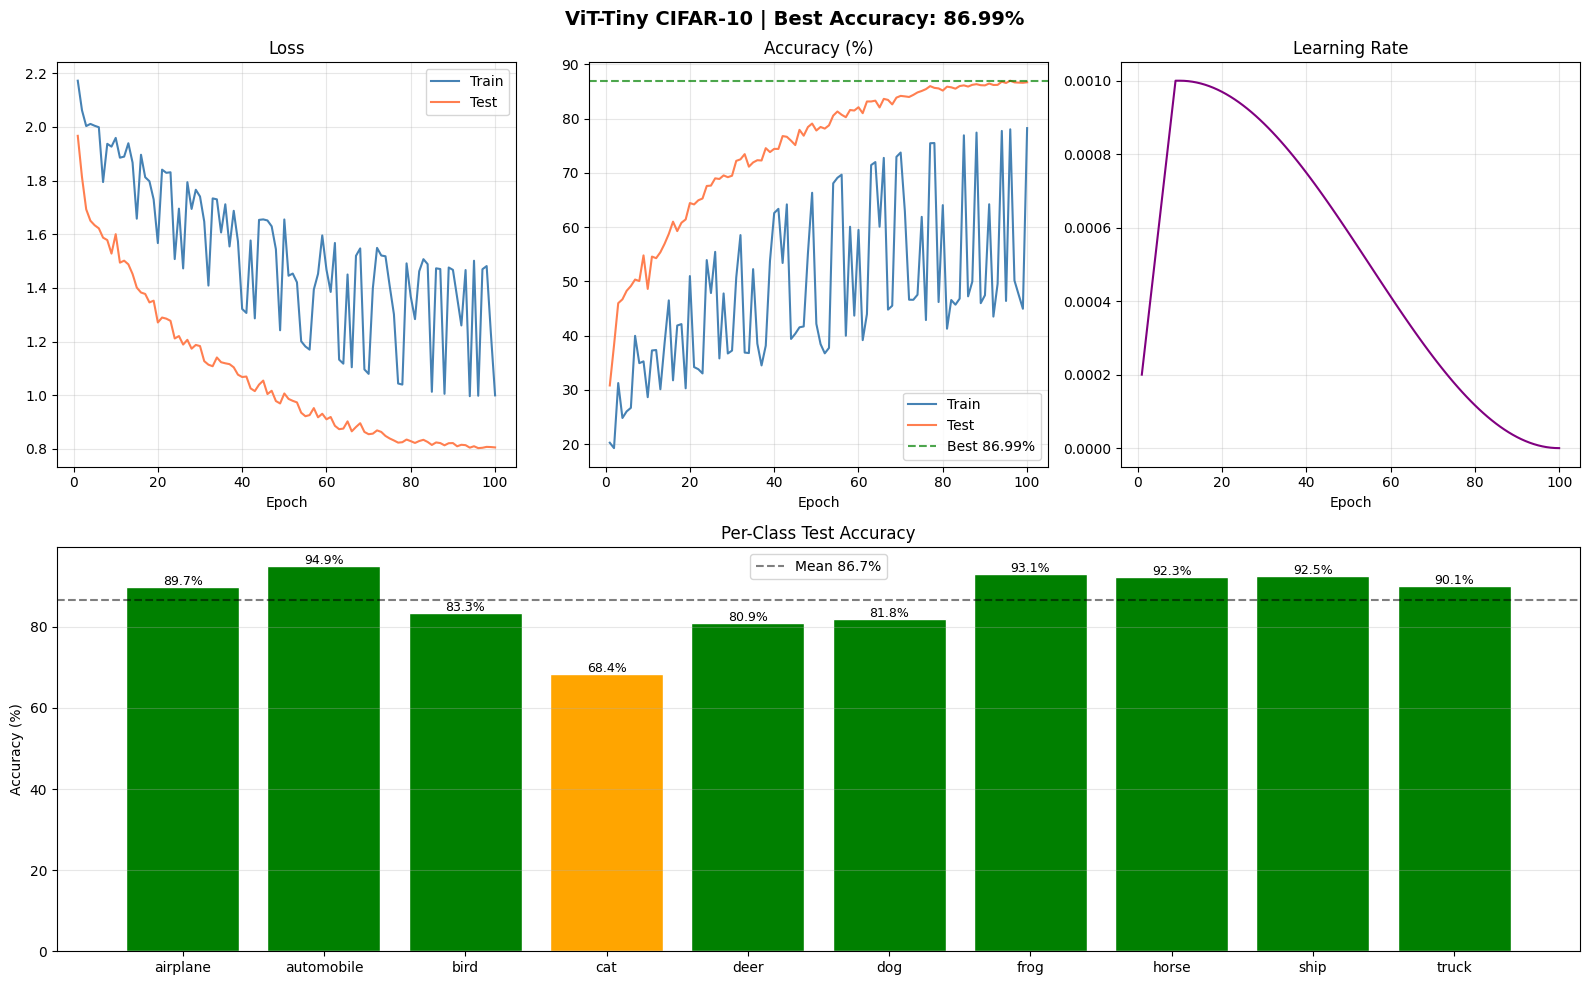

Plot saved as vit_results.png


In [25]:
fig = plt.figure(figsize=(16, 10))
gs  = gridspec.GridSpec(2, 3, figure=fig)

epochs = range(1, len(history['train_loss']) + 1)

# Loss curves
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(epochs, history['train_loss'], label='Train', color='steelblue')
ax1.plot(epochs, history['test_loss'],  label='Test',  color='coral')
ax1.set_title('Loss'); ax1.set_xlabel('Epoch'); ax1.legend(); ax1.grid(alpha=0.3)

# Accuracy curves
ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(epochs, history['train_acc'], label='Train', color='steelblue')
ax2.plot(epochs, history['test_acc'],  label='Test',  color='coral')
ax2.axhline(best_acc, linestyle='--', color='green', alpha=0.7, label=f'Best {best_acc:.2f}%')
ax2.set_title('Accuracy (%)'); ax2.set_xlabel('Epoch'); ax2.legend(); ax2.grid(alpha=0.3)

# LR schedule
ax3 = fig.add_subplot(gs[0, 2])
ax3.plot(epochs, history['lr'], color='purple')
ax3.set_title('Learning Rate'); ax3.set_xlabel('Epoch'); ax3.grid(alpha=0.3)

# Per-class accuracy
ax4 = fig.add_subplot(gs[1, :])
model.eval()
class_correct = [0] * 10
class_total   = [0] * 10

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        preds  = model(images).argmax(1).cpu()
        for pred, label in zip(preds, labels):
            class_total[label]   += 1
            class_correct[label] += (pred == label).item()

class_acc = [100 * class_correct[i] / class_total[i] for i in range(10)]
colors    = ['green' if a >= 70 else 'orange' if a >= 55 else 'red' for a in class_acc]
bars = ax4.bar(CLASSES, class_acc, color=colors, edgecolor='white')
ax4.axhline(np.mean(class_acc), linestyle='--', color='black', alpha=0.5, label=f'Mean {np.mean(class_acc):.1f}%')
ax4.set_title('Per-Class Test Accuracy'); ax4.set_ylabel('Accuracy (%)'); ax4.legend(); ax4.grid(alpha=0.3, axis='y')
for bar, acc in zip(bars, class_acc):
    ax4.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.5, f'{acc:.1f}%', ha='center', fontsize=9)

plt.suptitle(f'ViT-Tiny CIFAR-10 | Best Accuracy: {best_acc:.2f}%', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('vit_results.png', dpi=150, bbox_inches='tight')
plt.show()
print('Plot saved as vit_results.png')

## 💾 Step 11 — Download Checkpoint to Local Machine

In [26]:
# Download best checkpoint and results plot
from google.colab import files

best_ckpt = f'{CONFIG["save_dir"]}/best_vit_cifar10.pth'
if os.path.exists(best_ckpt):
    print(f'Downloading checkpoint ({os.path.getsize(best_ckpt)/1e6:.1f} MB)...')
    files.download(best_ckpt)
else:
    print('No checkpoint found — training may not have completed')

files.download('vit_results.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 📋 Step 12 — Final Summary

In [27]:
print('=' * 60)
print('FINAL RESULTS SUMMARY')
print('=' * 60)
print(f'Model:              ViT-Tiny')
print(f'Parameters:         {total_params:,}')
print(f'Dataset:            CIFAR-10')
print(f'Epochs trained:     {len(history["train_acc"])}')
print(f'Best test accuracy: {best_acc:.2f}%')
print(f'Final train acc:    {history["train_acc"][-1]:.2f}%')
print(f'Final test acc:     {history["test_acc"][-1]:.2f}%')
print()
print('Per-class accuracy:')
for cls, acc in zip(CLASSES, class_acc):
    bar = '█' * int(acc // 5)
    print(f'  {cls:<12} {acc:5.1f}%  {bar}')
print('=' * 60)

FINAL RESULTS SUMMARY
Model:              ViT-Tiny
Parameters:         5,356,234
Dataset:            CIFAR-10
Epochs trained:     100
Best test accuracy: 86.99%
Final train acc:    78.25%
Final test acc:     86.70%

Per-class accuracy:
  airplane      89.7%  █████████████████
  automobile    94.9%  ██████████████████
  bird          83.3%  ████████████████
  cat           68.4%  █████████████
  deer          80.9%  ████████████████
  dog           81.8%  ████████████████
  frog          93.1%  ██████████████████
  horse         92.3%  ██████████████████
  ship          92.5%  ██████████████████
  truck         90.1%  ██████████████████
